# NIRCam 1/f noise removal demo <a id='title'></a>
<hr style="border:1px solid gray">

## Import Libraries <a id='imp'></a>

In [1]:
import os
import numpy as np

import astropy
from astropy.io import fits
#from astropy.table import Table, vstack, unique

import astroquery
from astroquery.mast import Observations

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  # make colorbar same height as image plot
#from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch, AsinhStretch, SqrtStretch

## 1/f noise removal codes <a id='func'></a>

### Chris Willott: image1overf

https://github.com/chriswillott/jwst

In [46]:
from image1overf import sub1fimaging
#from image1overf_withbkgd_quadbyquad import sub1fimaging  # Bryan Hilbert's tweak: measure background in individual amplifiers

def Willott_1overf_correction(input_file, output_file=None, sigma_bgmask=3.0, sigma_1fmask=2.0, splitamps=True, usesegmask=True):
    with fits.open(input_file) as cal2hdulist:
        # Identify 'nan' values from the Superbias and set those to 0 for plotting
        cal2hdulist['SCI'].data = np.nan_to_num(cal2hdulist['SCI'].data)
        image_data = cal2hdulist['SCI'].data + 0
        
        if cal2hdulist['PRIMARY'].header['SUBARRAY']=='FULL' or cal2hdulist['PRIMARY'].header['SUBARRAY']=='SUB256':
            correcteddata = sub1fimaging(cal2hdulist,sigma_bgmask,sigma_1fmask,splitamps,usesegmask)
            if cal2hdulist['PRIMARY'].header['SUBARRAY']=='FULL':
                cal2hdulist['SCI'].data[4:2044,4:2044] = correcteddata  
            elif cal2hdulist['PRIMARY'].header['SUBARRAY']=='SUB256':
                cal2hdulist['SCI'].data[:252,:252] = correcteddata
            if output_file:
                cal2hdulist.writeto(output_file, overwrite=True)
    
    return cal2hdulist['SCI'].data

# Options:
# sigma_bgmask - sigma of outliers for masking when making background  (suggested value=3.0)
# sigma_1fmask - sigma of outliers for masking when making 1/f correction  (suggested value=2.0)
# splitamps - fit each of the 4 amps separately when full-frame  (set this to True when the field is sparse)
# usesegmask - whether to use a segmentation image as the mask before fitting 1/f stripes (recommend set to True in most cases)

### Micaela Bagley (CEERS): remstriping

Updated v0.4 code: https://utexas.box.com/s/q6h1mejlnmy26yazv2cuqw77kw4fij25

https://github.com/ceers/ceers-nircam/blob/main/stage1.md  
https://github.com/ceers/ceers-nircam/blob/main/remstriping.py  
https://github.com/ceers/ceers-nircam/blob/main/README.md#requiredpackages  

** Requires photutils 1.5 ** an older version with an older definition of <code>make_source_mask</code>

In [4]:
# Define this stuff before importing remstriping
# otherwise you'll get an error for missing CRDS_CONTEXT
home = os.path.expanduser("~")
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

import jwst

# Requires photutils 1.5: older version with older definition of make_source_mask
import photutils
from photutils import make_source_mask  # if this doesn't work, there's a problem
print('photutils', photutils.__version__)

import remstriping
import remstriping_v040 as remstriping
remstriping.__version__

# def measure_striping(image, origfilename, thresh=None, apply_flat=True, mask_sources=True, save_patterns=False)

# thresh (Optional [float]): fraction of masked amp-row pixels above which full row fit is used
# apply_flat (Optional [bool]): if True, identifies and applies the corresponding flat field before measuring striping pattern. 
#   Applying the flat first allows for a cleaner measure of the striping, especially for the long wavelength detectors. Default is True.
# mask_sources (Optional [bool]): If True, masks out sources in image before measuring the striping pattern 
#   so that source flux is not included in the calculation of the sigma-clipped median. Sources are identified using the Mirage seed images. Default is True.
# save_patterns (Optional [bool]): if True, saves the horizontal andvertical striping patterns to files called *horiz.fits and *vert.fits, respectively

/Users/dcoe/crds_cache


ImportError: cannot import name 'make_source_mask' from 'photutils' (/Users/dcoe/miniconda3/envs/dja/lib/python3.11/site-packages/photutils/__init__.py)

### Tom Williams (PHANGS): nircam_destriping

In [6]:
import nircam_destriping  # PHANGS

### Dan Coe: smooth1overf

simple smoothing of sigma-clipped medians for rows and columns

In [59]:
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve

def smooth_1overf_correction(data, row_kernel_length=99, column_kernel_length=9, iterations=3):
    for i in range(iterations):
        # horizontal striping: y-axis row medians
        kernel = np.ones(row_kernel_length) / float(row_kernel_length)
        ymean, ymedian, ystd = sigma_clipped_stats(data, sigma=3, maxiters=10, axis=1)
        ymedian_conv = convolve(ymedian, kernel, boundary='extend')
        data = data + ymedian_conv[:,np.newaxis] - ymedian[:,np.newaxis]
        
        # vertical striping: x-axis column medians
        kernel = np.ones(column_kernel_length) / float(column_kernel_length)
        xmean, xmedian, xstd = sigma_clipped_stats(data, sigma=3, maxiters=10, axis=0)
        xmedian_conv = convolve(xmedian, kernel, boundary='extend')
        data = data + xmedian_conv[np.newaxis,:] - xmedian[np.newaxis,:]

    return data

### Bernie Rauscher: NSClean

developed for NIRSpec with blank unilluminated pixels available

In [66]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.visualization import simple_norm

In [67]:
import photutils
print('photutils', photutils.__version__)
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources #, source_properties
from photutils.utils import calc_total_error
from photutils.segmentation import detect_sources, make_2dgaussian_kernel

photutils 1.9.0


/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_24447/4223897615.py:3: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, detect_sources, deblend_sources #, source_properties
/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_24447/4223897615.py:3: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, detect_sources, deblend_sources #, source_properties
/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_24447/4223897615.py:3: DeprecationWarning: `photutils.detect_sources` is a de

In [7]:
# Change this cell only if you are familair with GPU accelerated python.
# The development server's GPU has 32 GB of RAM. It may still run on
# NVIDIA GPUs with less RAM.
import os
os.environ['NSCLEAN_USE_CUPY'] = 'NO' # Change to YES to use GPU

# Load appropriate numerical libraries
if os.getenv('NSCLEAN_USE_CUPY') == 'YES':
    import cupy as cp
    import numpy as np
else:
    import numpy as np
    import numpy as cp

# Standard packages
from astropy.io import fits
from scipy.special import legendre
import matplotlib.pyplot as plt

# The NSClean package
import nsclean as nc

def make_signal_operator(nz, degree):
    """
    Make an operator that returns integrated signal when applied
    to up-the-ramp sampled data. This is the same as iterating over pixels
    calling numpy.polyfit, but it is much faster.
    
    Parameters: nz:int
                  Number of up-the-ramp points.
                degree:int
                  Fit degree. Set degree=1 to fit straight lines.
    """
    # We fit Legendre polynomials. Project up-the-ramp sample
    # indices to the interval [-1,+1].
    z = np.arange(-1,2,2/(nz-1), dtype=np.float32)[:nz]
    
    # Build the Legendre basis matrix. Each row is a Legendre
    # polynomial evauated at the points, z.
    B = []
    for _i in np.arange(degree+1):
        B.append(legendre(_i)(z))
    B = np.array(B).transpose()
    
    # The fitting operator is the Moore-Penrose inverse of B. 
    L = np.linalg.pinv(B)
    
    # 32-bits are sufficient, we only require slope, integrated
    # signal = 2*λ_1
    L = 2*np.float32(L)[1]
    
    # Done!
    return(L)

# Make the operator for fitting straight lines to 4 up-the-ramp points
# and computing the integrated signal per pixel in DN.
L = make_signal_operator(4, 1) # 4 up-the-ramp points, 1st degree fit

### Massimo Robberto: destriper

In [8]:
import numpy as np
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.convolution import Gaussian2DKernel,convolve
from photutils import Background2D, MedianBackground
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from jwst.datamodels import dqflags
from copy import deepcopy

def destriper(cal2hdulist):

    #Check subarray type and extract non-reference pixels
    image = cal2hdulist['SCI'].data#[4:2044,4:2044]
    image = np.nan_to_num(image)
    
    q1 = image[:,0:512]
    q2 = image[:,512:1024]
    q3 = image[:,1024:1536]
    q4 = image[:,1536:2048]
    #i_yy,i_xx = np.where((np.bitwise_and(dq, dqflags.group['DO_NOT_USE']) == 1))
    
    # The most basic: median filter across the rows
    v1 = np.median(q1,axis=1)
    x1 = np.transpose(np.tile(v1, (512,1)))
    v2 = np.median(q2,axis=1)
    x2 = np.transpose(np.tile(v2, (512,1)))
    v3 = np.median(q3,axis=1)
    x3 = np.transpose(np.tile(v3, (512,1)))
    v4 = np.median(q4,axis=1)
    x4 = np.transpose(np.tile(v4, (512,1)))

    #i1=(q1-x1)+np.median(x1)
    #i2=(q2-x2)+np.median(x2)
    #i3=(q3-x3)+np.median(x3)
    #i4=(q4-x4)+np.median(x4)
    i1=(q1-x1)+np.percentile(x1,65) #75 default
    i2=(q2-x2)+np.percentile(x2,65) #75 default
    i3=(q3-x3)+np.percentile(x3,65) #75 default
    i4=(q4-x4)+np.percentile(x4,65) #75 default

    # match the quadrants
    #print(np.median(i1[492:512,:]))
    #print(np.median(i2[0:10,:]))
    i2 = i2 + np.median(i1[492:512,:]) - np.median(i2[0:10,:])
    #print(np.median(i2[492:512,:]))
    #print(np.median(i3[0:10,:]))
    i3 = i3 + np.median(i2[492:512,:]) - np.median(i3[0:10,:])
    #print(np.median(i3[492:512,:]))
    #print(np.median(i4[0:10,:]))
    i4 = i4 + np.median(i3[492:512,:]) - np.median(i4[0:10,:])

    ## Rebuild a sky image
    image_out = np.empty((2048,2048))
    image_out[:,0:512] = i1
    image_out[:,512:1024] = i2
    image_out[:,1024:1536] = i3
    image_out[:,1536:2048] = i4
    
    return image_out


/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_24447/729623587.py:5: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground
/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_24447/729623587.py:5: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground


### Everett Schlawin: ROEBA

https://tshirt.readthedocs.io/en/latest/specific_modules/ROEBA.html

In [10]:
## ROEBA
# !pip install tshirt

import tshirt 
from tshirt.tests import test_phot_algorithms
from tshirt.pipeline.instrument_specific import rowamp_sub

Could not import ccdproc, so some CCD-like processing may not work.


## Download image data from MAST <a id='dirs'></a>

In [11]:
mast_dir = 'mast:jwst/product' # Download from MAST
data_dir = 'data'  # save downloaded data
results_dir = 'results'  # save results

os.makedirs(data_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

In [19]:
# JWST images to be analyzed
image_files = [ 
    "jw01345001001_10201_00001_nrca3_cal.fits",  # CEERS
    "jw01074001001_02101_00001_nrca1_cal.fits",  # stars
    "jw01334001001_02101_00001_nrca1_cal.fits",  # star cluster
    "jw02107025001_02101_00001_nrcb2_cal.fits",  # galaxy
    "jw02731001001_02101_00004_nrca1_cal.fits",  # nebula
]

In [20]:
for image_file in image_files:
    # Download file (if not already downloaded)
    mast_path  = os.path.join(mast_dir, image_file)
    local_path = os.path.join(data_dir, image_file)
    Observations.download_file(mast_path, local_path=local_path)

INFO: Found cached file data/jw01345001001_10201_00001_nrca3_cal.fits with expected size 117538560. [astroquery.query]
INFO: Found cached file data/jw01074001001_02101_00001_nrca1_cal.fits with expected size 117538560. [astroquery.query]
INFO: Found cached file data/jw01334001001_02101_00001_nrca1_cal.fits with expected size 117538560. [astroquery.query]
INFO: Found cached file data/jw02107025001_02101_00001_nrcb2_cal.fits with expected size 117538560. [astroquery.query]
INFO: Found cached file data/jw02731001001_02101_00004_nrca1_cal.fits with expected size 117538560. [astroquery.query]


# Plotting functions

In [21]:
def display_image(data, vmin, vmax, title, filename, xsize=12, ysize=12, aspect=1, cmap='viridis', save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=20)

    fig = plt.figure(figsize=(xsize, ysize))
    ax = fig.add_subplot(1, 1, 1)
    
    data = np.nan_to_num(data)  # replace nan with zero
    im = ax.imshow(data, origin='lower', vmin=vmin, vmax=vmax, aspect=aspect, cmap=cmap)
    plt.title(title)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.12)
    plt.colorbar(im, cax=cax, label='MJy/sr')

    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)    

In [22]:
def display_images(image_data, corrected_data, vmin, vmax, corrected_title, filename, xsize=12, ysize=12, aspect=1, cmap='viridis',
                  save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes',  labelsize=10)
    plt.rc('axes',  titlesize=12)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True, layout='compressed')
    axs = axs.flatten()
    
    plot_data = image_data, corrected_data
    
    for i in range(2):
        data = plot_data[i]
        data = np.nan_to_num(data)  # replace nan with zero
        im = axs[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    
    axs[0].set_title(os.path.basename(filename), fontsize=12)
    axs[1].set_title(corrected_title, fontsize=12)
    
    plt.colorbar(im, ax=axs, label='MJy/sr')
    
    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)

In [23]:
def display_all_images(image_data_list, title=None, aspect=1, cmap='viridis', save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes',  labelsize=10)
    plt.rc('axes',  titlesize=12)

    n = len(image_data_list)
    #height = 6
    #width = n * height
    height = 6.7
    width = 30
    fig, axs = plt.subplots(1, n, figsize=(width,height), sharex=True, sharey=True, layout='compressed')
    axs = axs.flatten()
        
    for i, data in enumerate(image_data_list):
        data = np.nan_to_num(data)  # replace nan with zero
        vmin, vmax = plot_limits[image_files[i]]
        im = axs[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
        axs[i].set_title(os.path.basename(image_files[i][:-5]), fontsize=18)
    
    #plt.tight_layout()

    if title:
        plt.suptitle(title, fontsize=28)

    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)

#display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

In [24]:
# Manually set plot limits scaling for each dataset
plot_limits = {}
plot_limits["jw01074001001_02101_00001_nrca1_cal.fits"] = -0.5,  1
plot_limits["jw01334001001_02101_00001_nrca1_cal.fits"] = -0.02, 0.5
plot_limits["jw02107025001_02101_00001_nrcb2_cal.fits"] = -0.99, 5.5
plot_limits["jw02731001001_02101_00004_nrca1_cal.fits"] = -3, 25
plot_limits["jw01345001001_10201_00001_nrca3_cal.fits"] = -0.02, 0.5

# Plot all input images

In [25]:
image_data_list = []

for i, image_file in enumerate(image_files):
    input_file  = os.path.join(data_dir, image_file)
    data = fits.getdata(input_file)
    image_data_list.append(data)

In [26]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 14

In [27]:
plot_output_dir = 'montages'

In [ ]:
plot_output_file = 'input_images.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
title = 'original images'
display_all_images(image_data_list, save_plot=plot_output_file, title=title)

# Run 1/f noise correction on all data

## Chris Willott: image1overf

In [29]:
method = 'image1overf'
author = 'Chris Willott'

### Correct each amplifier individually

In [28]:
# Corrected files will be saved in output directory, by default named "calibrated"
output_dir = 'corrected/image1overf'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/image1overf'

In [ ]:
#corrected_title = "Corrected for 1/f noise using %s's method" % author
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title += ' (individual amplifiers)'
corrected_title

In [ ]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir,   image_file)
    output_file = image_file.replace('_cal.fits','_cal_1overf.fits')
    output_file = os.path.join(output_dir, output_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        corrected_data = Willott_1overf_correction(input_file, output_file=output_file, splitamps=True)
    corrected_data_list.append(corrected_data)

plot_output_file = 'Willott_splitamps.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
title = corrected_title
display_all_images(corrected_data_list, save_plot=plot_output_file, title=title)

### Correct full rows (better for crowded fields)

In [42]:
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title += ' (full rows)'
print(corrected_title)

Corrected for 1/f noise using Chris Willott's method image1overf (full rows, no sources)


In [43]:
output_dir = 'corrected/image1overf/fullrows'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/image1overf/fullrows-nosourcemask'

In [44]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir, image_file)
    output_file = image_file.replace('_cal.fits','_cal_1overf.fits')
    output_file = os.path.join(output_dir, output_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        corrected_data = Willott_1overf_correction(input_file, output_file=output_file, splitamps=False)

    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits


jw01074001001_02101_00001_nrca1_cal.fits


jw01334001001_02101_00001_nrca1_cal.fits


jw02107025001_02101_00001_nrcb2_cal.fits


jw02731001001_02101_00004_nrca1_cal.fits


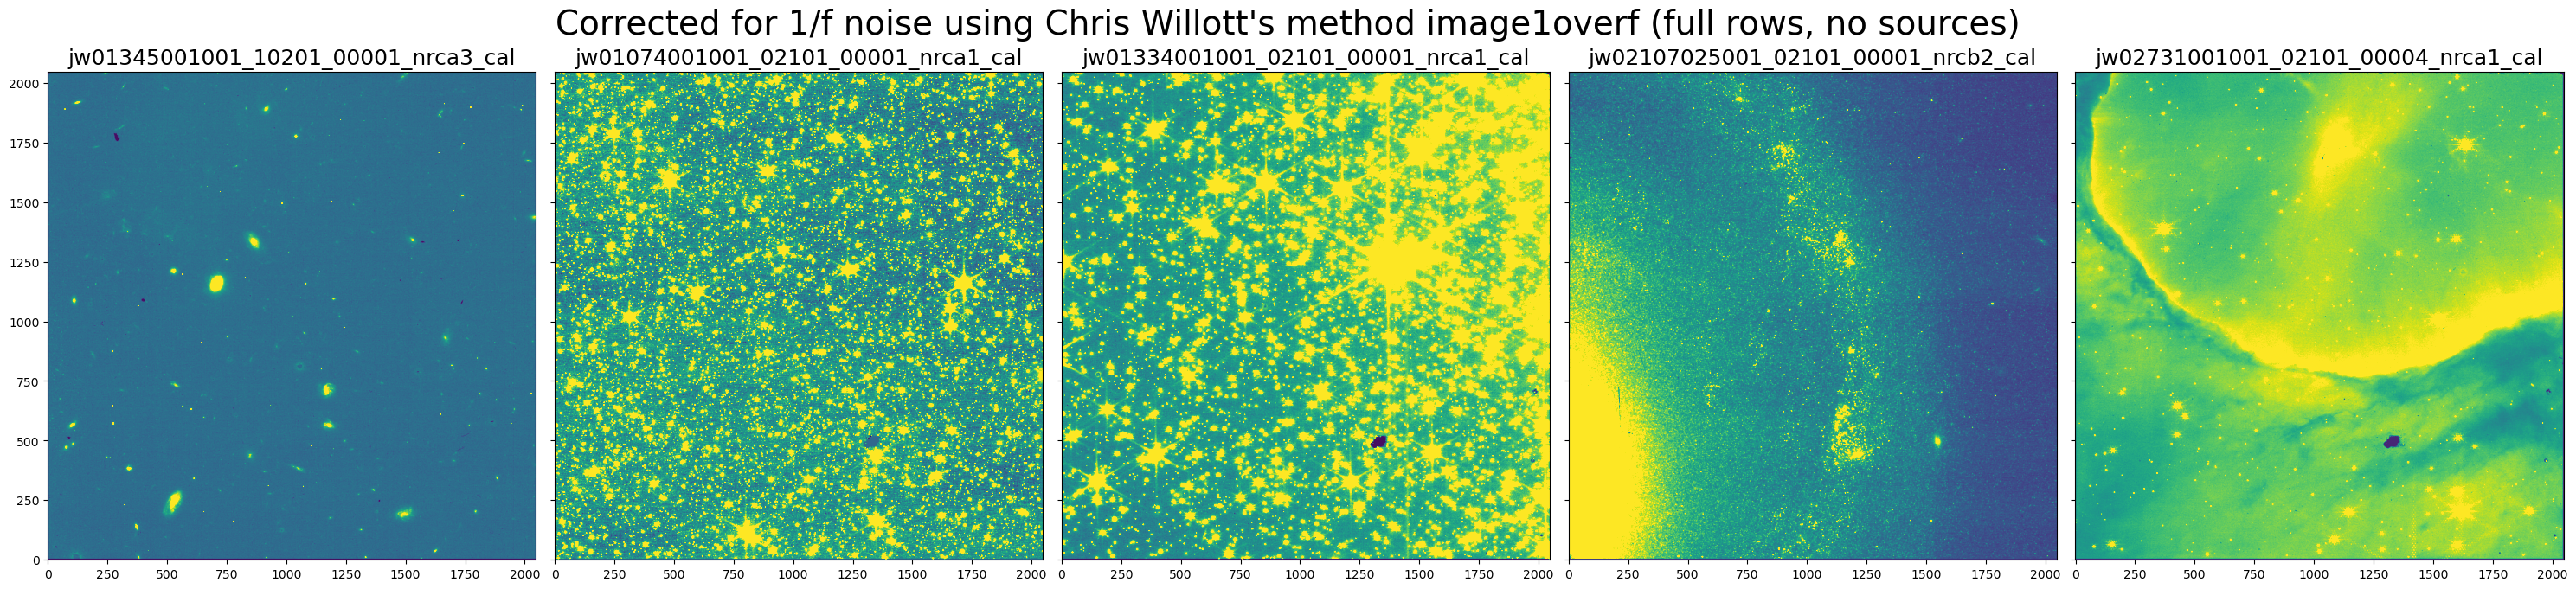

In [45]:
plot_output_file = 'Willott_fullrows-nosourcemask.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

### Correct full rows, no source mask

In [42]:
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title += ' (full rows, no sources)'
print(corrected_title)

Corrected for 1/f noise using Chris Willott's method image1overf (full rows, no sources)


In [43]:
output_dir = 'corrected/image1overf/fullrows-nosourcemask'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/image1overf/fullrows-nosourcemask'

In [44]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir, image_file)
    output_file = image_file.replace('_cal.fits','_cal_1overf.fits')
    output_file = os.path.join(output_dir, output_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        corrected_data = Willott_1overf_correction(input_file, output_file=output_file, splitamps=False, usesegmask=False)

    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits


jw01074001001_02101_00001_nrca1_cal.fits


jw01334001001_02101_00001_nrca1_cal.fits


jw02107025001_02101_00001_nrcb2_cal.fits


jw02731001001_02101_00004_nrca1_cal.fits


In [ ]:
plot_output_file = 'Willott_fullrows-nosourcemask.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

## Micaela Bagley: remstriping

In [ ]:
method = 'remstriping v0.4'
author = 'Micaela Bagley'
#corrected_title = "Corrected for 1/f noise using %s's method" % author
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title

In [ ]:
thresh = 0.8

# Corrected file will be saved in output directory, by default named "calibrated"
#output_dir = remstriping.OUTPUTDIR
output_dir = 'corrected'
output_dir = os.path.join(output_dir, 'v0.4')
output_dir = os.path.join(output_dir, 'thresh%.1f' % thresh)
remstriping.OUTPUTDIR = output_dir
os.makedirs(output_dir, exist_ok=True)  # for output files
print(output_dir)

In [ ]:
for i, image_file in enumerate(image_files):
    input_file = os.path.join(data_dir, image_file)
    print(input_file)
    output_file = os.path.join(output_dir, image_file)
    pre1f_file = input_file.replace('.fits','_pre1f.fits')
    if not os.path.exists(output_file):
        remstriping.measure_striping(input_file, pre1f_file, thresh=thresh, apply_flat=False, mask_sources=True) #, save_patterns=True)

### Correct full rows (better for crowded fields)

In [ ]:
thresh = -1
mask_sources = False

# Corrected file will be saved in output directory, by default named "calibrated"
#output_dir = remstriping.OUTPUTDIR
output_dir = 'corrected'
output_dir = os.path.join(output_dir, 'v0.4')
output_dir = os.path.join(output_dir, 'thresh%.1f_mask%s' % (thresh, mask_sources))
remstriping.OUTPUTDIR = output_dir
os.makedirs(output_dir, exist_ok=True)  # for output files
print(output_dir)

for i, image_file in enumerate(image_files):
    input_file = os.path.join(data_dir, image_file)
    print(input_file)
    pre1f_file = input_file.replace('.fits','_pre1f.fits')
    remstriping.measure_striping(input_file, pre1f_file, thresh=thresh, apply_flat=False, mask_sources=mask_sources) #, save_patterns=True)

### Show images

In [ ]:
method = 'remstriping v0.4'
author = 'Micaela Bagley'
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)

thresh = 0.8; mask_sources=True
#thresh = -1; mask_sources=False

output_dir = 'corrected'
output_dir = os.path.join(output_dir, 'v0.4')
if mask_sources:
    output_dir = os.path.join(output_dir, 'thresh%.1f' % thresh)
    corrected_title += ' (individual amplifiers)'
else:
    output_dir = os.path.join(output_dir, 'thresh%.1f_mask%s' % (thresh, mask_sources))
    corrected_title += ' (full rows)'

corrected_data_list = []
for i, image_file in enumerate(image_files):
    input_file = os.path.join(data_dir, image_file)
    pre1f_file = input_file.replace('.fits','_pre1f.fits')
    #remstriping.measure_striping(input_file, pre1f_file, thresh=thresh, apply_flat=False, mask_sources=True, save_patterns=True)
    output_file = os.path.join(output_dir, image_file)
    #image_data = fits.getdata(input_file)
    corrected_data = fits.getdata(output_file)
    corrected_data_list.append(corrected_data)

plot_output_file = 'Bagley_thresh%.1f.png' % thresh
if mask_sources == False:
    plot_output_file = plot_output_file.replace('.png', '_maskFalse.png')

plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

## Everett Schlawin: ROEBA

In [47]:
# Corrected file will be saved in output directory, by default named "calibrated"
output_dir = 'corrected/ROEBA'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/ROEBA'

In [48]:
method = 'ROEBA'
author = 'Everett Schlawin'
#corrected_title = "Corrected for 1/f noise using %s's method" % author
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title += ' (individual amplifiers)'
corrected_title

"Corrected for 1/f noise using Everett Schlawin's method ROEBA (individual amplifiers)"

In [49]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir,   image_file)
    output_file = os.path.join(output_dir, image_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        with fits.open(input_file) as cal2hdulist:

            #cal2hdulist = imnans2any(cal2hdulist, 0.)  
            data = cal2hdulist['SCI'].data#[4:2044,4:2044]
            data = np.nan_to_num(data)  # replace nan with zero
            #define background 
            bkg = np.zeros(data.shape,dtype=bool)
            median = np.nanmedian(data)
            sigma = np.nanstd(data)

            i_yy,i_xx = (np.where(data <= median +0.*sigma))
            bkg[i_yy,i_xx] = True
            #print(bkg)
            
            imdict = {'data':cal2hdulist['SCI'].data, 'bkgmask':bkg}
            corrected_data, model_1overf = rowamp_sub.do_backsub(imdict['data'], amplifiers=1, backgMask=imdict['bkgmask'])
            cal2hdulist['SCI'].data = corrected_data# imdict['data']
            
            cal2hdulist.writeto(output_file)
        
    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits
jw01074001001_02101_00001_nrca1_cal.fits
jw01334001001_02101_00001_nrca1_cal.fits
jw02107025001_02101_00001_nrcb2_cal.fits
jw02731001001_02101_00004_nrca1_cal.fits


In [ ]:
plot_output_file = 'ROEBA_splitamps.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
title = corrected_title
display_all_images(corrected_data_list, save_plot=plot_output_file, title=title)

## Massimo Robberto: destryper

In [52]:
# Corrected file will be saved in output directory, by default named "calibrated"
#output_dir = 'corrected_destryper'
output_dir = 'corrected/destriper'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/destriper'

In [53]:
method = 'destriper'
author = 'Massimo Robberto'
#corrected_title = "Corrected for 1/f noise using %s's method" % author
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title += ' (individual amplifiers)'
corrected_title

"Corrected for 1/f noise using Massimo Robberto's method destriper (individual amplifiers)"

In [54]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir,   image_file)
    output_file = os.path.join(output_dir, image_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        with fits.open(input_file) as cal2hdulist:
            corrected_data = destriper(cal2hdulist)
            cal2hdulist['SCI'].data = corrected_data
            cal2hdulist.writeto(output_file)
        
    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits
jw01074001001_02101_00001_nrca1_cal.fits
jw01334001001_02101_00001_nrca1_cal.fits
jw02107025001_02101_00001_nrcb2_cal.fits
jw02731001001_02101_00004_nrca1_cal.fits


In [ ]:
plot_output_file = 'Robberto_splitamps.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
title = corrected_title
display_all_images(corrected_data_list, save_plot=plot_output_file, title=title)

# Dan Coe: smooth1overf

In [56]:
output_dir = 'corrected/Coe-smooth'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/Coe-smooth'

In [60]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir, image_file)
    output_file = os.path.join(output_dir, image_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        data = fits.getdata(input_file)
        #data = np.nan_to_num(data)  # replace nan with zero
        corrected_data = smooth_1overf_correction(data)
        fits.PrimaryHDU(corrected_data).writeto(output_file)

    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits


jw01074001001_02101_00001_nrca1_cal.fits
jw01334001001_02101_00001_nrca1_cal.fits
jw02107025001_02101_00001_nrcb2_cal.fits
jw02731001001_02101_00004_nrca1_cal.fits


In [61]:
method = 'smooth1overf'
author = 'Dan Coe'
corrected_title = "Corrected for 1/f noise using %s's %s" % (author, method)
corrected_title

"Corrected for 1/f noise using Dan Coe's smooth1overf"

In [ ]:
plot_output_file = 'Coe_fullrows.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

# NSClean

In [63]:
output_dir = 'corrected/nsclean/fullrows'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/nsclean/fullrows'

In [ ]:
fits.PrimaryHDU(corrected_data).writeto(output_file, overwrite=True)

In [64]:
def NSClean_1overf_correction(input_file, output_file):
    data = fits.getdata(input_file)
    
    # https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html
    # Measure background and set detection threshold
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
    pixel_SNR = 1.5
    threshold = bkg.background + (pixel_SNR * bkg.background_rms)
    
    # Before detection, smooth image with Gaussian FWHM = 3 pixels
    fwhm = 9
    kernel = make_2dgaussian_kernel(fwhm, size=3)
    convolved_data = convolve(data, kernel)
    
    # Detect and deblend
    npixels = 9
    segm_detect  = detect_sources(convolved_data,  threshold,   npixels=npixels)
    #segm_deblend = deblend_sources(convolved_data, segm_detect, npixels=npixels, nlevels=32, contrast=0.001)
    
    data = fits.getdata(input_file)  # yes, reload, because it gets altered
    image_data = np.nan_to_num(data)
    source_pixels = segm_detect.make_source_mask()  # size=50 to dilate sources
    background_pixel_mask = np.logical_not(source_pixels)
    
    cleaner = nc.NSClean('NRS2', background_pixel_mask.transpose())  # Instantiate an NSClean object; NRS2 flips data before processing; NRS1 doesn't
    corrected_data = cleaner.clean(image_data.transpose(), buff=True)
    image_data = np.nan_to_num(data)
    corrected_data = corrected_data.transpose()
    output_file = os.path.join(output_dir, image_file)
    fits.PrimaryHDU(corrected_data).writeto(output_file, overwrite=True)
    return(corrected_data, background_pixel_mask)

In [71]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir, image_file)
    output_file = os.path.join(output_dir, image_file)

    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        corrected_data, background_pixel_mask = NSClean_1overf_correction(input_file, output_file=output_file)
        
        data = fits.getdata(input_file)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        norm = simple_norm(data, 'sqrt', percent=99.)
        ax1.imshow(data, origin='lower', interpolation='nearest', norm=norm)
        ax2.imshow(background_pixel_mask, origin='lower', interpolation='nearest', cmap='gray')
        plt.tight_layout()

    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits
jw01074001001_02101_00001_nrca1_cal.fits
jw01334001001_02101_00001_nrca1_cal.fits
jw02107025001_02101_00001_nrcb2_cal.fits
jw02731001001_02101_00004_nrca1_cal.fits


In [74]:
method = 'NSClean'
author = 'Bernie Rauscher'
corrected_title = "Corrected for 1/f noise using %s's %s" % (author, method)
corrected_title += ' (only intended for NIRSpec data)'
corrected_title

"Corrected for 1/f noise using Bernie Rauscher's NSClean (only intended for NIRSpec data)"

In [ ]:
plot_output_file = 'NSClean_fullrows.png'
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)

## PHANGS

In [77]:
nircam_destriping.DESTRIPING_METHODS

['row_median', 'median_filter', 'remstripe', 'pca']

In [91]:
destriping_method = 'median_filter'
destriping_method = 'row_median'
destriping_method = 'remstripe'  # similar to Micaela Bagley's implementation, but preserves background levels
#destriping_method = 'pca'  # Takes a long time ~15 minutes per image
output_dir = os.path.join('corrected_PHANGS', 'fullrows', destriping_method)
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected_PHANGS/fullrows/remstripe'

In [88]:
corrected_data_list = []
for i, image_file in enumerate(image_files):
    print(image_file)
    input_file  = os.path.join(data_dir,   image_file)
    output_file = os.path.join(output_dir, image_file)
    
    if os.path.exists(output_file):
        corrected_data = fits.getdata(output_file)
    else:
        cleaner = nircam_destriping.NircamDestriper(input_file, output_file, destriping_method=destriping_method, quadrants=False)
        full_noise_model = cleaner.run_destriping()
        corrected_data = fits.getdata(output_file)

    corrected_data_list.append(corrected_data)

jw01345001001_10201_00001_nrca3_cal.fits
jw01074001001_02101_00001_nrca1_cal.fits
jw01334001001_02101_00001_nrca1_cal.fits
jw02107025001_02101_00001_nrcb2_cal.fits
jw02731001001_02101_00004_nrca1_cal.fits


In [89]:
method = destriping_method
author = 'PHANGS'
corrected_title = "Corrected for 1/f noise using %s's method %s" % (author, method)
corrected_title = corrected_title.replace('_', ' ')  # otherwise title shifts plots down a bit
corrected_title += ' (full rows)'
corrected_title

"Corrected for 1/f noise using PHANGS's method remstripe (full rows)"

In [ ]:
plot_output_file = 'PHANGS_%s.png' % destriping_method
plot_output_file = os.path.join(plot_output_dir, plot_output_file)
display_all_images(corrected_data_list, save_plot=plot_output_file, title=corrected_title)